In [16]:
!curl -L https://figshare.com/ndownloader/files/37681653 -o data/bfsongrepo/sober.repo1.gy6or6.032312.cbin.not.mat.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  155M  100  155M    0     0  12.0M      0  0:00:12  0:00:12 --:--:-- 14.2M


In [22]:
!tar -xzf data/bfsongrepo/sober.repo1.gy6or6.032312.cbin.not.mat.tar.gz -C data/bfsongrepo

Import VocalPy

In [22]:
import pandas as pd

import vocalpy as voc

Load data

In [14]:
data_dir = ('data/bfsongrepo/gy6or6/032312/')

cbin_paths = voc.paths.from_dir(data_dir, 'cbin')
notmats = voc.paths.from_dir(data_dir, '.not.mat')

In [16]:
audios = [voc.Audio.read(cbin_path) for cbin_path in cbin_paths]
annots = [voc.Annotation.read(notmat_path, format='notmat') for notmat_path in notmats]

In this notebook we want to embed the syllables of Bengalese finch song with UMAP.

In [69]:
import numpy as np


def get_segment_audio(audios, annots, labelset=list('iabcdefghjk'), min_length=1024):
    """Get audio for every segment in every sequence.
    Pad audio for each segment so they are all the same size.
    Here we use the naive approach of just padding all segments 
    with neighoring audio so they are the same size as the largest.
    Note this might not be a good idea for the general case,
    if there are very brief silent gaps
    (or no silent gaps) between segments.
    
    audios : list
        of vocalpy.Audio
    seqs: list
        of vocalpy.Sequence, sequences segmented from ``audios``
    """
    audios_out = []
    labels_out = []
    for annot, audio in zip(annots, audios):

        # ---- convert sequence of units to array of starts and stop times
        start_times = annot.data.seq.onsets_s
        stop_times = annot.data.seq.offsets_s

        start_inds = np.round(start_times * audio.samplerate).astype(int)
        stop_inds = np.round(stop_times * audio.samplerate).astype(int)
        
        labels = annot.data.seq.labels

        for start, stop, label in zip(start_inds, stop_inds, labels):
            if label not in labelset:
                continue
            segment_audio = audio.data[start:stop]
            if segment_audio.shape[-1] < min_length:
                continue
            audios_out.append(
                voc.Audio(data=segment_audio, samplerate=audio.samplerate)
            )
            labels_out.append(label)
    return audios_out, labels_out

In [70]:
segment_audios, segment_labels = get_segment_audio(audios, annots)

In [90]:
spect_params = {'fft_size': 512, 'step_size': 64, 'transform_type': 'log_spect'}
callback = voc.signal.spectrogram.spectrogram
spect_maker = voc.SpectrogramMaker(callback=callback, spect_params=spect_params)
segment_spects = spect_maker.make(segment_audios, parallelize=True)

[########################################] | 100% Completed | 109.37 ms


In [91]:
widths = [
    segment_spect.data.shape[-1]
    for segment_spect in segment_spects
]
pad_length = max(widths)

In [92]:
def pad_spectrogram(spectrogram, pad_length):
    """ Pads a spectrogram to being a certain length"""
    excess_needed = pad_length - np.shape(spectrogram)[1]
    pad_left = np.floor(float(excess_needed) / 2).astype("int")
    pad_right = np.ceil(float(excess_needed) / 2).astype("int")
    return np.pad(
        spectrogram, [(0, 0), (pad_left, pad_right)], "constant", constant_values=0
    )

In [99]:
X = np.array(
    [pad_spectrogram(segment_spect.data, pad_length)
     for segment_spect in segment_spects]
)

In [100]:
X.shape

(10767, 257, 90)

In [101]:
X = X.reshape(X.shape[0], -1)

In [102]:
X.shape

(10767, 23130)

## Now the easy part

In [103]:
import umap

In [116]:
umapper = umap.UMAP(min_dist=0.5)

In [117]:
out = umapper.fit_transform(X)

/home/pimienta/miniconda3/envs/vocalpy-notebooks-env/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


## Finally we visualize
adapted from https://github.com/timsainb/avgn_paper/blob/V2/avgn/visualization/projections.py

We make a color palette for the labels

In [118]:
pal = sns.color_palette("tab20", n_colors=len(np.unique(segment_labels)))
lab_dict = {lab: pal[i] for i, lab in enumerate(np.unique(segment_labels))}
colors = np.array([lab_dict[i] for i in segment_labels])

In [119]:
import matplotlib.pyplot as plt

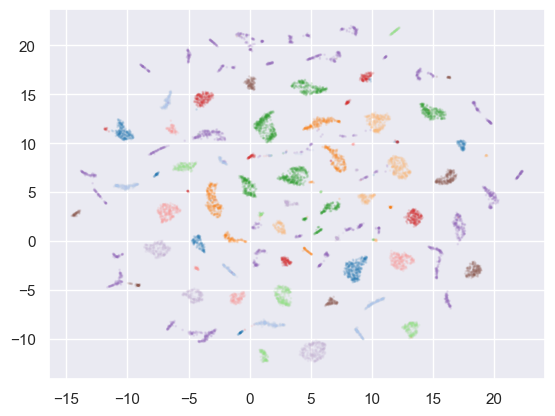

In [120]:
fig, ax = plt.subplots()
ax.scatter(
    out[:, 0],
    out[:, 1],
    rasterized=True,
    alpha=0.1,
    s=1,
    color=colors,
)